# Functional Principal Component Analysis with Partial Differential Equation Regularization
Ilenia Di Battista, Alessandro Palummo @ fdaPDE Team, MOX, Department of Mathematics, Politecnico di Milano, Italy

`fdaPDE` (Palummo et al., 2025) is a C++ library with an interface to R and Python for *physics-informed spatial and functional data analysis*, at the intersection of statistics and numerical analysis. The library provides advanced statistical methods designed for data located over complex spatial domains, ranging from irregular planar regions and curved surfaces to linear networks and volumes, possibly evolving over time. The class of methods implemented in `fdaPDE` features regularization terms based on Partial Differential Equations (PDEs), which allow incorporating information derived from the physics of the problem under study into the statistical modeling. This makes `fdaPDE` an extremely flexible tool for the analysis of complex data. For a review of this class of methods, refer to  Sangalli (2021).

This notebook describes the `fdaPDE` Python interface for a class of dimensionality reduction approaches: **functional Principal Component Analysis**

## Model

**Functional Principal Component Analysis** (fPCA) extends the traditional multivariate PCA to the case of functional data. The idea of fPCA is to describe the variability of complex functional data as a linear combination of few smooth and highly informative basis functions called functional principal components (fPCs). This data summary provides insights into the dominant modes of variation and allows for dimensionality reduction. These properties make fPCA a valuable tool in functional data analysis (FDA).

We present the fPCA model derived in  Lila et al. (2016), which proposes to estimate the first $r$ principal component functions $f_1, \ldots, f_r$ and corresponding scores vector $\boldsymbol{s}_1, \ldots, \boldsymbol{s}_r$ by minimization of the following functional:

$$
J(\{f_m\}, S) = \sum_{i=1}^n \sum_{j=1}^l \left (x_{ij}-\sum_{m=1}^r s_{mi}f_m(\mathbf{p}_j) \right )^2 +  \sum_{m=1}^r \lambda_m \|\mathbf{s}_m\|_2^2 \int_{\mathcal{D}} (\Delta f_m(\mathbf{p}))^2 \, \text{d}\mathbf{p}\,.
$$


The first term is a **data-fidelity** component, based on the characterization of fPCA as the best $r-$basis approximation of the data. In particular, $x_{ij}$ is the value of the observed function for subject $i$ at spatial location $\mathbf{p}_j\,,$ for $i=1,\ldots,n$ and $j=1,\ldots,l\,;$ $s_{mi}$ represents the Principal Component (PC) score of the $i$th subject along component $m\,,$ for $m = 1,\ldots,r\,;$ $f_m(\mathbf{p}_j)$ is the value of the $m$th fPC at location $\mathbf{p}_j\,.$ The second term promote the **smoothness** of the estimated fPCs to account for the functional nature of the data. The trade-off between data-fidelity and smoothness of the fPCs is balanced by the $\{\lambda_m\}_m$ **smoothing parameters**, which can be selected using data-driven criteria, such as the minimization of **Generalized Cross-Validation** (GCV).

In this notebook we describe how the `fdaPDE` library gives easy access to the described physics-informed fPCA for low-rank data reduction.

We start by loading some additional Python libraries and helper functions used for graphical purposes only:

In [1]:
# Import additiional libraries 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display

## Application to spatial transcriptomics data

As a benchmark application in genomics, we analyze data from patients with a **HER2-positive breast tumor**. The dataset consists of measurements of gene expression levels across a section of breast cancer tissue. Gene expression levels are quantified by counting the number of times each gene is transcribed at specific spatial locations, using spatial transcriptomics techniques. In this analysis, we focus on gene expression data from a single patient.

Below is a histological image of the tissue under study, annotated by a pathologist as detailed in Shang & Zhou (2022).

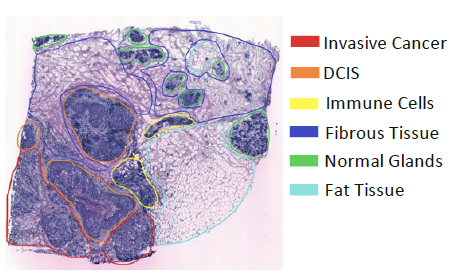

In [3]:
display(Image("../Data/fPCA_2D/fPCA_2D_histological_image.png"))

Figure 1: Histological image of the tissue under study.
</div>

We introduce the following terminology:

* **DCIS (Ductal Carcinoma In Situ):** an early, non-invasive form of breast cancer in which abnormal cells are confined to the milk ducts and have not spread to surrounding tissues;

* **Immune Cells:** cells that are part of the immune system, responsible for defending the body against infections and disease.


### 1. Data

The data -- preprocessed following the procedure described in Shang & Zhou (2022) -- comprise expression levels of 302 genes measured at 604 spatial locations across the tissue, represented as a two-dimensional domain.

In [4]:
## [DATA]
# Load the data
counts    = pd.read_csv("../Data/fPCA_2D/fPCA_2D_counts.csv"   , index_col=0)
locations = pd.read_csv("../Data/fPCA_2D/fPCA_2D_locations.csv", index_col=0)

# Gene names
gene_names = counts.index.tolist()  

# Convert in numpy.ndarray
counts = counts.values         
locations = locations.values    

# Data content
# - counts:         (numpy.ndarray)     n_genes x n_locations
# - locations:      (numpy.ndarray)     n_locations x 2

We visualize the expression of the *ERBB2* gene, which encodes the HER2 protein. It is well established that overexpression of *ERBB2* is a key biomarker for breast cancer. In particular, the tumor under study has been identified as HER2-positive. As expected, the expression of *ERBB2* is elevated in regions annotated as cancerous by the pathologist, reflecting the gene's central role in tumor progression.

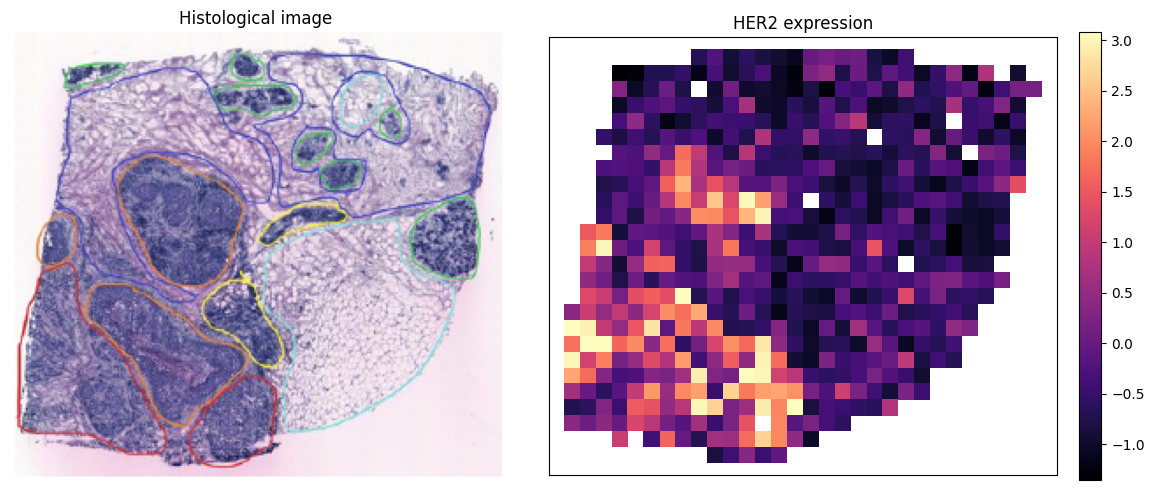

In [5]:
# ERBB2 gene index 
idx_HER2 = 21
vals = counts[idx_HER2, :]

# Static plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Left panel
img = plt.imread("../Data/fPCA_2D/fPCA_2D_reduced_histological_image.png")
ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Histological image")

# Right panel 
cmap = matplotlib.colormaps["magma"]
norm = plt.Normalize(vmin=np.nanmin(vals), vmax=np.nanmax(vals))

sc = ax[1].scatter(
    locations[:, 0],
    locations[:, 1],
    c=vals,
    cmap=cmap,
    norm=norm,
    s=135,
    marker="s",
    linewidths=0
)

ax[1].set_aspect("equal")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("HER2 expression")
cbar = fig.colorbar(sc, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Figure 2: Reduced histological image of the tissue under study (left); expression of the *ERBB2* gene (right).


### 2. Spatial domain

We now proceed with the fPCA analysis. As a first step, we import a **regular mesh** of the spatial domain under consideration, reading the mesh nodes, mesh elements and domain boundaries from already preprocessed files.

In [6]:
## [MESH]
# Read mesh nodes, boundary nodes and mesh elements
mesh_nodes = pd.read_csv("../Data/fPCA_2D/nodes.csv"   , index_col=0).to_numpy()
mesh_cells = pd.read_csv("../Data/fPCA_2D/cells.csv"   , index_col=0).to_numpy()
mesh_bound = pd.read_csv("../Data/fPCA_2D/boundary.csv", index_col=0).to_numpy()


# Print shapes
print(f"Mesh nodes shape: {mesh_nodes.shape}")
print(f"Mesh cells shape: {mesh_cells.shape}\n")

Mesh nodes shape: (4881, 2)
Mesh cells shape: (9513, 3)



Next, we embed the geometrical structure in a `Mesh` object imported from the geometry module of the fdaPDE library.

In [7]:
# Import Mesh from the geometry module
from fdaPDE.geometry import Mesh

mesh_tissue = Mesh(
    nodes    = mesh_nodes,
    cells    = mesh_cells,
    boundary = mesh_bound
)

# Print short summary of the mesh
print(mesh_tissue)

2D mesh
Bounding box:   xmin: 3.0 ymin: -34.0 xmax: 32.0 ymax: -9.0
Number of nodes: 4881
Number of cells: 9513


The next objective is to visualize the fPCs in order to examine the most significant modes of variation in the data. We fit the model to the centered data, as fPCA assumes that the input functions have **zero mean**. 

We use the triangulation just created to define the spatial support of a `GeoFrame` object, which we will use to fit an SR-PDE model for the estimation of a smooth mean field.

In [8]:
# Import GeoFrame from fdaPDE
from fdaPDE import GeoFrame

# Create the geoframe and add the layer
tissue = GeoFrame(domain = mesh_tissue)
tissue.insert(
    layer      = "sample_mean", 
    layer_type = "point",
    geo        = locations,
    data       = pd.DataFrame({"sample_mean": np.mean(counts, axis=0)  })
)

print(tissue)

Geoframe with 1 layer
Bounding box:   xmin: 3.0 ymin: -34.0 xmax: 32.0 ymax: -9.0
Number of nodes: 4881
Number of cells: 9513

Layer: sample_mean
Type:  POINT
Dims:  607, 1
First 6 data rows:
                        sample_mean
                <POINT>     <flt64>
 (22.000000, -9.000000)   -0.131431
 (11.000000, -9.000000)   -0.030234
 (19.000000, -9.000000)   -0.082480
 (18.000000, -9.000000)   -0.035236
 (21.000000, -9.000000)   -0.101357
 (23.000000, -9.000000)   -0.213520



### 3. Smooth approximation of the mean function

We apply smoothing to the column-wise means to derive a smooth approximation of the mean function. Here, the optimal smoothing parameter is selected via GCV minimization using the `GridSearch` optimizer.

In [9]:
# Import FeFunction, SRPDE, GCV, GridSearch from fdaPDE
from fdaPDE.fem import FeFunction
from fdaPDE.models import SRPDE, GCV
from fdaPDE.optimization import GridSearch

## [ISOTROPIC SMOOTHING WITH OPTIMAL SMOOTHING PARAMETER]
# Set up the finite element function (order 1)
f = FeFunction(domain = mesh_tissue, fe_type = "P1")

# Proposed values for the smoothing parameter
lambda_grid = 10.0 ** np.linspace(-5, -2, 10)

# Isotropic smoothing model
smoothing_model = SRPDE("sample_mean ~ f", data = tissue)

# Isotropic smoothing fit
smoothing_fit = smoothing_model.fit( calibration_ = GCV(optimizer = GridSearch(grid = lambda_grid)) )


We visualize the mean as follows:

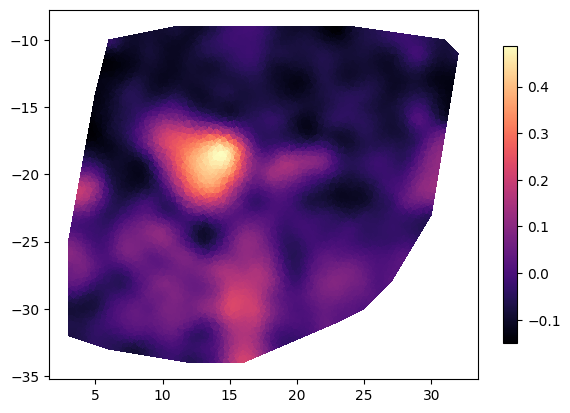

In [10]:
# Static plot
img_smoothed_mean = f.plot(cmap = "magma")

Figure 3: Smooth approximation of the mean function.

### 4. fPCA to the centered data

We are now ready to fit the fPCA model to the centered data. First, we construct a new `GeoFrame` object, supported on the same `Mesh` object.

In [11]:
# Center the data
centered_counts = counts - smoothing_model.fitted

# Create the geoframe
tissue_fpca = GeoFrame(domain=mesh_tissue)

# Add layer with data to the geoframe object
tissue_fpca.insert(
    "gene_expression",
    layer_type = "point",
    geo        = locations
)

tissue_fpca["gene_expression"].add_column("X", centered_counts.T)   

print(tissue_fpca) 

Geoframe with 1 layer
Bounding box:   xmin: 3.0 ymin: -34.0 xmax: 32.0 ymax: -9.0
Number of nodes: 4881
Number of cells: 9513

Layer: gene_expression
Type:  POINT
Dims:  607, 1
First 6 data rows:
                                X
                <POINT>   <flt64>
 (22.000000, -9.000000) -0.781438
 (11.000000, -9.000000) -0.627116
 (19.000000, -9.000000) -0.717226
 (18.000000, -9.000000) -0.089052
 (21.000000, -9.000000)  0.424511
 (23.000000, -9.000000)  0.439225



We aaply the described fPCA with the `fPCA` function of the `fdaPDE` package, setting to 6 the number of PCs to be extracted. 

In [12]:
# Import fPCA from fdaPDE
from fdaPDE.models import fPCA

## [FUNCTIONAL PRINCIPAL COMPONENT ANALYSIS]
# fPCA model
fpca_model = fPCA(
    column = "X",
    data   = tissue_fpca
)

# Proposed values for the smoothing parameter
lambda_grid = 10.0 ** np.arange(-2, 2.0 + 0.5, 0.5)

# fPCA fit
fpca_model.fit(
    npc_         = 6, 
    calibration_ = GCV(optimizer=GridSearch(grid=lambda_grid))
)

We visualize the **explained variance** to determine the *optimal number of principal components*. A noticeable increase in explained variance is observed between the third and fourth components, suggesting that retaining the first three fPCs may be appropriate.

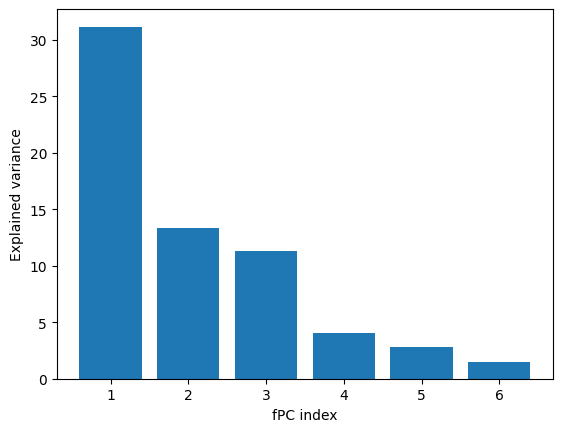

In [13]:
# Static plot
explained_variance = np.var(fpca_model.scores, axis=0)

plt.figure()

plt.bar(
    np.arange(1, len(explained_variance) + 1),
    explained_variance
)

plt.xlabel("fPC index")
plt.ylabel("Explained variance")
plt.show()

Figure 4: Explained variance.
 
According to the figure above, we select the first 3 PCs only:

In [14]:
# Select the optimal number of PCs
npc = 3

# fPCs
fPCs = fpca_model.pcs[:, :npc].copy()

for i in range(npc):
    col = fPCs[:, i]
    # Flip fPCs to have coherent signs in the visualization 
    if np.nanmax(col) < -np.nanmin(col):
        fPCs[:, i] = -col


which we visualize as follow:

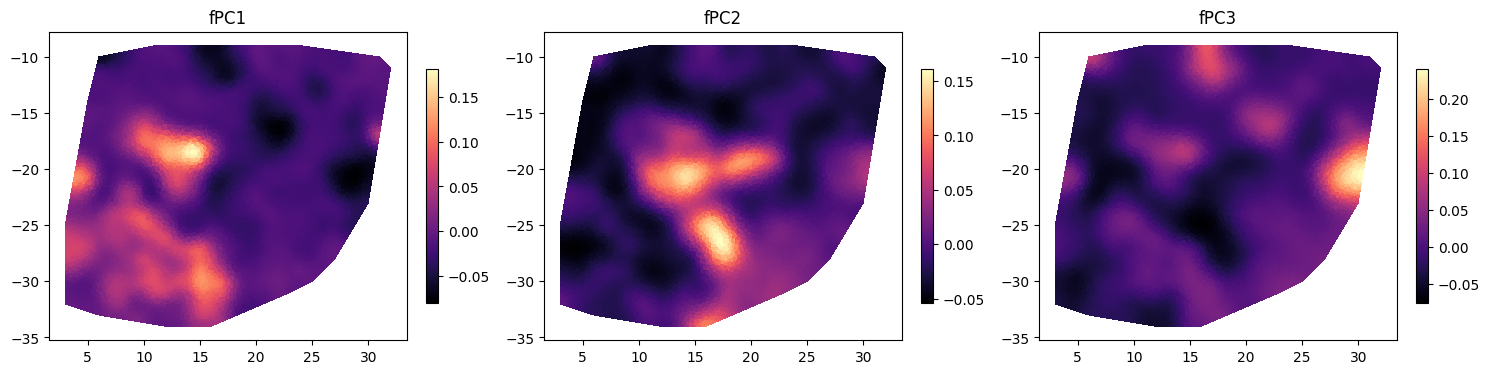

In [15]:
# Static plot 
npc = [0, 1, 2]  

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, comp in enumerate(npc):
    f_pc = FeFunction(mesh_tissue, fe_type="P1", coeff=fPCs[:,comp])
    f_pc.plot(
        ax    = axes[i],          
        title = f"fPC{comp+1}",
        cmap  = "magma"
    )

plt.tight_layout()
plt.show()

Figure 5: First 3 functional principal components.

We summarize the interpretation of the first 3 fPCs relative to the histological image:

* **fPC1**: Shows activation in **cancerous regions**;

* **fPC2**: Shows activation in **immune cell regions**;

* **fPC3**: Shows activation in **normal glandular tissue**.

The fPCA model can also be used to generate **smooth reconstructions** of the original gene activation maps. As an illustration, we revisit the *ERBB2* gene and reconstruct its activation map using the extracted fPCs.

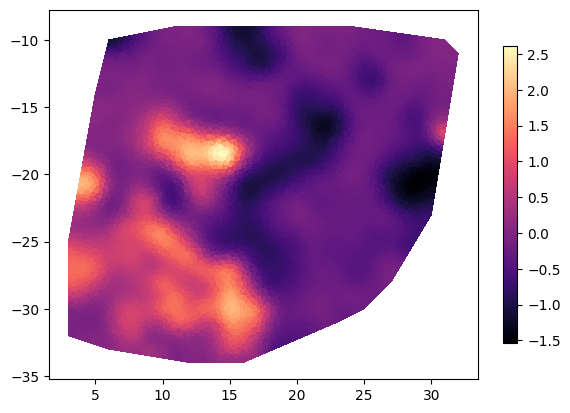

In [16]:
# Select fPCs associated with the ERBB2 gene
erbb2 = fpca_model.scores[idx_HER2, :3] @ fPCs[:, :3].T

# Static plot
f_pc = FeFunction(
        mesh_tissue,
        fe_type="P1",
        coeff= erbb2 
    )

img_smooth_erbb2 = f_pc.plot(cmap="magma")


Figure 6: Smooth reconstruction of the original gene activation map associated to the *ERBB2* gene using the extracted fPCs.

Moreover, examining the score vector associated with the *ERBB2* gene reveals a strong activation along fPC1, which is consistent with the interpretation of fPC1 as capturing cancer-related variation.

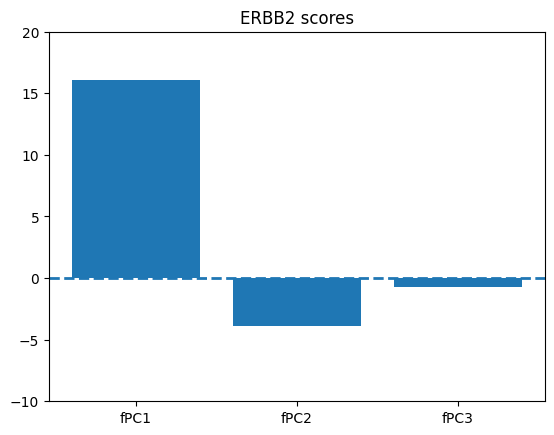

In [17]:
# Scores
scores_gene = fpca_model.scores[idx_HER2, :3]

# Static plot
labels = ["fPC1", "fPC2", "fPC3"]

plt.figure()
plt.bar(labels, scores_gene)
plt.title("ERBB2 scores")
plt.ylim(-10, 20)
plt.axhline(0, linestyle="--", linewidth=2)
plt.show()

*ERBB2* is the gene with the highest score along fPC1, further supporting its association with cancer-related activity captured by this component, as shown in the figure below.

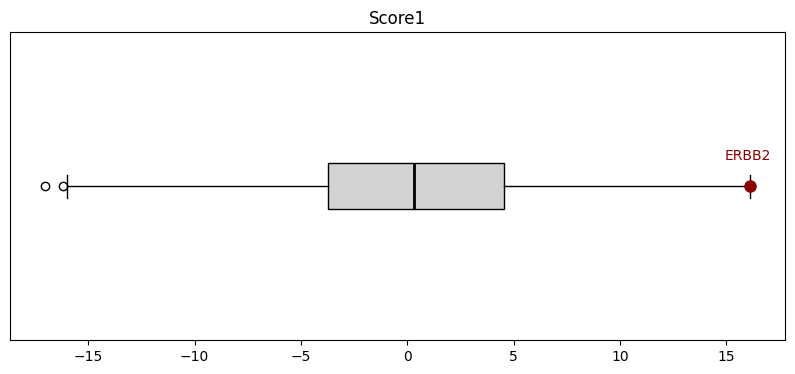

In [18]:
# Gene name
idx_max = np.argmax(fpca_model.scores[:, 0])
# > ERBB2

# Static plot
scores_max = fpca_model.scores[:, 0]
idx_max = np.argmax(scores_max)
max_val = scores_max[idx_max]

fig, ax = plt.subplots(figsize=(10, 4))  

ax.boxplot(
    scores_max,
    vert=False,
    patch_artist=True,                
    boxprops=dict(facecolor="lightgray", edgecolor="black"),
    medianprops=dict(color="black", linewidth=2),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black")
)

ax.set_title("Score1")
ax.set_yticks([])
ax.plot(max_val, 1, 'o', color="darkred", markersize=8)

ax.text(
    max_val - 1.2,    
    1 + 0.1,                
    gene_names[idx_max],
    color="darkred",
    verticalalignment="center"
)

plt.show()

Figure 7: Scores for the ERBB2 gene.


## References
Lila, E., Aston, J. A., & Sangalli, L. M. (2016). Smooth principal component analysis over two-dimensional manifolds with an application to neuroimaging. Annals of Applied Statistics, 10(4), 1854–1879. https://doi.org/10.1214/16-AOAS975

Palummo, A., Clemente, A., Sangalli, E., Arnone, Formaggia, L., & Maria, L. (2025). fdaPDE: Physics-informed statistical learning. url: https://github.com/fdaPDE/fdaPDE-R.

Sangalli, L. M. (2021). Spatial regression with partial differential equation regularisation. International Statistical Review, 89(3), 505–531. https://doi.org/10.1111/insr.12444

Shang, L., & Zhou, X. (2022). Spatially aware dimension reduction for spatial transcriptomics. Nature Communications, 13(1).

